In [254]:
import numpy as np
import networkx as nx

from networkx.algorithms.dag import ancestors, descendants

import matplotlib.pyplot as plt
import seaborn as sns

In [200]:
def ancestor_history_layout(population_node_list):
    pos = {}
    for i, nodes in enumerate(population_node_list):
        ys = np.linspace(-10, 10, len(nodes))
        for node, y in zip(nodes, ys):
            pos[node] = i, y
    return pos

In [291]:
def apply_alpha(colours: list, alpha: float) -> list:
    return list(map(lambda c: tuple(x + (1 - x) * (1 - alpha) for x in c), colours))

In [442]:
# populations = [100, 90, 75, 50, 25, 13, 5]
# populations = [743, 635, 429, 276, 203, 163, 120, 100, 102, 84, 69, 63, 60, 68, 85, 78, 67, 61, 56]  # europe approx every 50y
populations = np.repeat(25, 12)
population_node_list = []

node_index = 0
for i, p in enumerate(populations):
    x = 0 if i == 0 else sum(populations[:i])
    population_node_list.append(list(range(1 + x, p + x + 1)))
    
# [np.array(x) for x in population_node_list]

In [452]:
G = nx.DiGraph()

for generation, nodes in enumerate(population_node_list):
    for node in nodes:
        G.add_node(node, generation=generation)
        
for g, population in enumerate(population_node_list):
    if g + 1 < len(population_node_list):
        print(f"{g} | {population}")
        for child in population:
            p_max, p_min = min(population_node_list[g+1]), max(population_node_list[g+1])
            
            # TODO: make sure parent_x != parent_y
            parent_x, parent_y = np.random.randint(p_max, p_min, 2)
            print(f"  {child} | ({parent_x}, {parent_y})")
            G.add_edge(child, parent_x, generation=g)
            G.add_edge(child, parent_y, generation=g)


0 | [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
  1 | (49, 27)
  2 | (28, 35)
  3 | (49, 45)
  4 | (26, 26)
  5 | (28, 41)
  6 | (29, 30)
  7 | (47, 32)
  8 | (28, 38)
  9 | (47, 37)
  10 | (42, 27)
  11 | (36, 33)
  12 | (48, 26)
  13 | (45, 43)
  14 | (26, 46)
  15 | (35, 40)
  16 | (30, 48)
  17 | (45, 26)
  18 | (36, 32)
  19 | (37, 49)
  20 | (35, 35)
  21 | (48, 35)
  22 | (27, 32)
  23 | (38, 30)
  24 | (38, 29)
  25 | (32, 35)
1 | [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
  26 | (66, 52)
  27 | (58, 53)
  28 | (57, 70)
  29 | (60, 71)
  30 | (51, 69)
  31 | (67, 70)
  32 | (51, 58)
  33 | (68, 58)
  34 | (54, 62)
  35 | (67, 69)
  36 | (55, 57)
  37 | (58, 68)
  38 | (65, 52)
  39 | (55, 63)
  40 | (72, 51)
  41 | (68, 74)
  42 | (65, 55)
  43 | (68, 67)
  44 | (53, 51)
  45 | (59, 69)
  46 | (68, 54)
  47 | (51, 55)
  48 | (56, 67)
  49 | (55, 74)
  50 | (59, 58)
2 | [51,

In [462]:
common_ancestors = []
mrca_generation = len(populations) + 1  # most recent common ancestor generation

for generation, nodes in enumerate(population_node_list):
    if generation > 0:
        for node in nodes:
            n_ancestors = len(ancestors(G, node))
            if n_ancestors == len(population_node_list[generation-1]):
                common_ancestors.append(node)
                print(f"generation {generation} | (node {node}) n_ancestors={n_ancestors} -> COMMON ANCESTOR")
                if generation < mrca_generation:
                    mrca_generation = generation
            else:
                print(f"generation {generation} | (node {node}) n_ancestors={n_ancestors}")
                
print(f"\nbase common ancestors: {common_ancestors}")
print(f"most recent common ancestor generation: {mrca_generation}")

implied_common_ancestors = set(common_ancestors)
for node in common_ancestors:
    implied_common_ancestors.update(descendants(G, node))
    
implied_common_ancestors = list(implied_common_ancestors)
    
print(f"implied common ancestors: {implied_common_ancestors}")


no_descendant_nodes = [node for node, in_degree in G.in_degree() if in_degree==0 and node > populations[0]]
print(f"no relation or descendant nodes: {no_descendant_nodes}")


identical_anscestors_generation = None
for generation, nodes in enumerate(population_node_list):
    if len(set(nodes).intersection(set(implied_common_ancestors) | set(no_descendant_nodes))) == len(nodes):
        identical_anscestors_generation = generation
        break
        
print(f"identical anscestors generation: {identical_anscestors_generation}")

generation 1 | (node 26) n_ancestors=4
generation 1 | (node 27) n_ancestors=3
generation 1 | (node 28) n_ancestors=3
generation 1 | (node 29) n_ancestors=2
generation 1 | (node 30) n_ancestors=3
generation 1 | (node 31) n_ancestors=0
generation 1 | (node 32) n_ancestors=4
generation 1 | (node 33) n_ancestors=1
generation 1 | (node 34) n_ancestors=0
generation 1 | (node 35) n_ancestors=5
generation 1 | (node 36) n_ancestors=2
generation 1 | (node 37) n_ancestors=2
generation 1 | (node 38) n_ancestors=3
generation 1 | (node 39) n_ancestors=0
generation 1 | (node 40) n_ancestors=1
generation 1 | (node 41) n_ancestors=1
generation 1 | (node 42) n_ancestors=1
generation 1 | (node 43) n_ancestors=1
generation 1 | (node 44) n_ancestors=0
generation 1 | (node 45) n_ancestors=3
generation 1 | (node 46) n_ancestors=1
generation 1 | (node 47) n_ancestors=2
generation 1 | (node 48) n_ancestors=3
generation 1 | (node 49) n_ancestors=3
generation 1 | (node 50) n_ancestors=0
generation 2 | (node 51) 

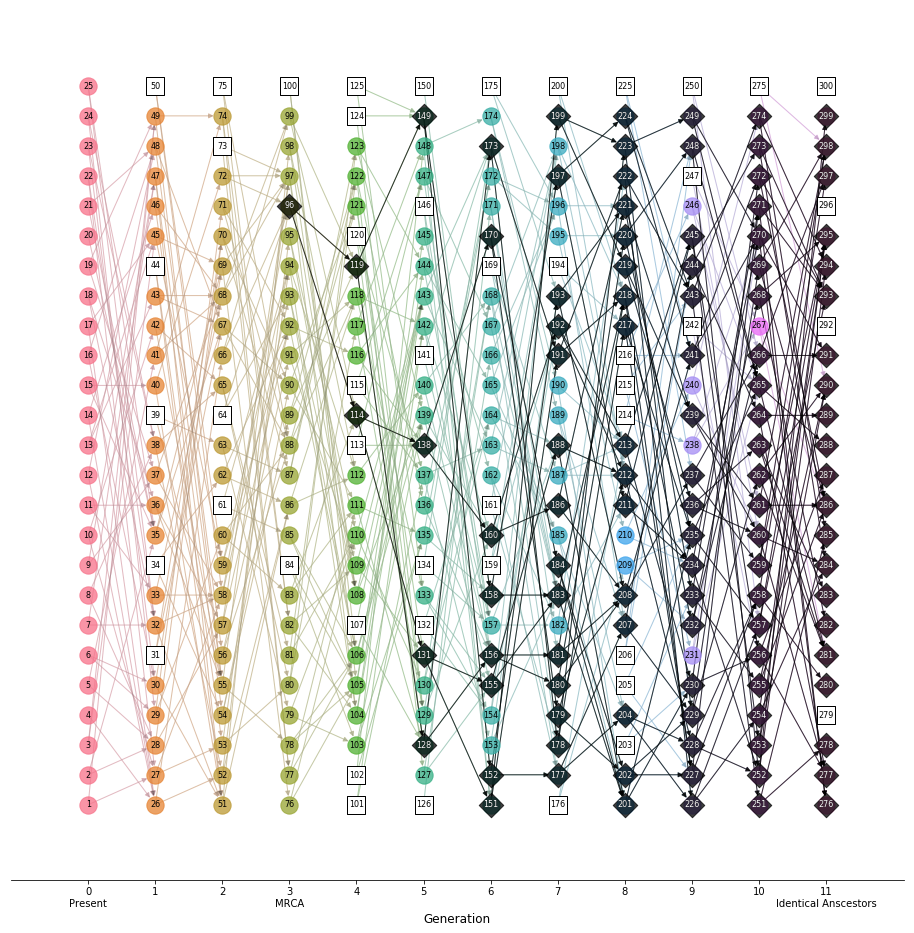

In [467]:
fig, ax = plt.subplots(figsize=(16, 16))

label_font_size = 8

pos = ancestor_history_layout(population_node_list)

shell_colours = sns.color_palette("husl", len(population_node_list))

for shell, colour in zip(population_node_list, shell_colours):
    nx.draw_networkx_nodes(G, pos, nodelist=shell, node_color=colour, alpha=0.75)
    
for g, colour in zip(range(len(population_node_list)), shell_colours):
    generation_edges = [(u, v) for u, v, d in G.edges(data=True) if d['generation']==g]
    nx.draw_networkx_edges(
        G, pos, 
        edgelist=generation_edges, 
        edge_color=apply_alpha([colour for _ in range(len(generation_edges))], 0.33)  # embedded alpha,
    )
    
nx.draw_networkx_labels(G, pos, font_size=label_font_size)

# common ancestors + implied
nx.draw_networkx_nodes(
    G, pos, 
    nodelist=implied_common_ancestors, 
    node_color='k', 
    alpha=0.75, 
    node_shape='D'
)

nx.draw_networkx_edges(
    G, pos, 
    edgelist=[(u, v) for u, v, d in G.edges(data=True) if u in implied_common_ancestors], 
    edge_color='k',
    alpha=0.75
)

nx.draw_networkx_labels(
    G, pos, 
    labels={c: c for c in implied_common_ancestors}, 
    font_color='w',
    font_size=label_font_size
)



# common ancestors + implied (draw descendant edges)

common_ancestor_descendants = []
for a in implied_common_ancestors:
    common_ancestor_descendants.extend(ancestors(G, a))
    
# print(common_ancestor_descendants)

nx.draw_networkx_edges(
    G, pos, 
    edgelist=[(u, v) for u, v, d in G.edges(data=True) if u in common_ancestor_descendants], 
    edge_color='k',
    alpha=0.10
)

# ancestor lines that died out (no relation to present/initial generation)
no_descendant_nodes = [node for node, in_degree in G.in_degree() if in_degree==0 and node > populations[0]]

nodes = nx.draw_networkx_nodes(
    G, pos, 
    nodelist=no_descendant_nodes, 
    node_color='w', 
#     edgecolor='k',
    node_shape='s'
)
nodes.set_edgecolor('k')



# plot formatting
plt.xlabel('Generation', fontsize=12)
locs, labels = plt.xticks()
labels = list(map(str, range(len(populations))))
labels[0] = f"{0}\nPresent"
labels[mrca_generation] = f"{mrca_generation}\nMRCA"

if identical_anscestors_generation is not None:
    labels[identical_anscestors_generation] = f"{identical_anscestors_generation}\nIdentical Anscestors"
    
plt.xticks(np.arange(len(labels)), labels)

ax.get_yaxis().set_visible(False)

ax.spines['top'].set_color(None)
ax.spines['left'].set_color(None)
ax.spines['right'].set_color(None)

# plt.tight_layout()

plt.show()